In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import datetime
from hatch import create_token_batches, TokenBatch, Commons
from convictionvoting import trigger_threshold
from policies import *
from network_utils import *
from IPython.core.debugger import set_trace
from entities import Participant, Proposal
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

In [2]:
# For the Flask backend

# Commons/Augmented Bonding Curve parameters
hatchers = 60
proposals = 3
hatch_tribute = 0.2
vesting_80p_unlocked = 60
exit_tribute = 0.35
# kappa = 2, default option set in abcurve.py, there is no way to reach it from here for now

# Conviction Voting parameters
days_to_80p_of_max_voting_weight = 10  # used in ProposalFunding.su_calculate_gathered_conviction
max_proposal_request = 0.2  # will be passed to trigger_threshold()

In [3]:
def update_collateral_pool(params, step, sL, s, _input):
    commons = s["commons"]
    s["collateral_pool"] = commons._collateral_pool
    return "collateral_pool", commons._collateral_pool


def update_token_supply(params, step, sL, s, _input):
    commons = s["commons"]
    s["token_supply"] = commons._token_supply
    return "token_supply", commons._token_supply


def update_funding_pool(params, step, sL, s, _input):
    commons = s["commons"]
    s["funding_pool"] = commons._funding_pool
    return "funding_pool", commons._funding_pool

In [4]:
contributions = [np.random.rand() * 10e5 for i in range(hatchers)]
token_batches, initial_token_supply = create_token_batches(contributions, 0.1, vesting_80p_unlocked)

commons = Commons(sum(contributions), initial_token_supply, hatch_tribute=0.2, exit_tribute=0.35)
network = bootstrap_network(token_batches, proposals, commons._funding_pool, commons._token_supply, max_proposal_request)

initial_conditions = {
    "network": network,
    "commons": commons,
    "funding_pool": commons._funding_pool,
    "collateral_pool": commons._collateral_pool,
    "token_supply": commons._token_supply,
    "sentiment": 0.5,
}

partial_state_update_blocks = [
    {
        "policies": {
            "generate_new_participants": GenerateNewParticipant.p_randomly,
        },
        'variables': {
            'network': GenerateNewParticipant.su_add_to_network,
            'commons': GenerateNewParticipant.su_add_investment_to_commons,
        }
    },
    {
        "policies": {},
        "variables": {
            "funding_pool": update_funding_pool,
            "collateral_pool": update_collateral_pool,
            "token_supply": update_token_supply,
        }
    },
    {
        "policies": {
            "generate_new_proposals": GenerateNewProposal.p_randomly,
        },
        "variables": {
            "network": GenerateNewProposal.su_add_to_network,
        }
    },
    {
        "policies": {
            "generate_new_funding": GenerateNewFunding.p_exit_tribute_of_average_speculator_position_size,
        },
        "variables": {
            "network": GenerateNewFunding.su_add_funding,
        }
    },
    {
        "policies": {},
        "variables": {
            "network": ProposalFunding.su_update_age_and_conviction_thresholds,
        }
    },
    {
        "policies": {},
        "variables": {
            "network": ProposalFunding.su_update_gathered_conviction,
        }
    },
    {
        "policies": {
            "decide_which_proposals_should_be_funded": ProposalFunding.p_compare_conviction_and_threshold
        },
        "variables": {
            "network": ProposalFunding.su_compare_conviction_and_threshold_make_proposal_active,
            "commons": ProposalFunding.su_compare_conviction_and_threshold_deduct_funds_from_funding_pool,
        }
    },
]

In [5]:

# TODO: make it explicit that 1 timestep is 1 day
simulation_parameters = {
    'T': range(150),
    'N': 1,
    'M': {
        # "sentiment_decay": 0.01, #termed mu in the state update function
        # "trigger_threshold": trigger_threshold,
        # "min_proposal_age_days": 7, # minimum periods passed before a proposal can pass,
        # "sentiment_sensitivity": 0.75,
        # 'min_supp':50, #number of tokens that must be stake for a proposal to be a candidate
        "debug": True,
        "days_to_80p_of_max_voting_weight": days_to_80p_of_max_voting_weight,
        "max_proposal_request": max_proposal_request,
    }
}

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc) # Do not use multi_proc, breaks ipdb.set_trace()
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x7f4058fa3190>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f4058fa3190>]
ProposalFunding: Proposal 60 has 0 conviction, and needs 154679896.1673637 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151734668.40326694 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153698529.1721515 to pass
ProposalFunding: Proposal 60 has 0 conviction, and needs 154679285.99498785 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151734352.63398802 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153698018.01066715 to pass
ProposalFunding: Proposal 60 has 0 conviction, and needs

ProposalFunding: Proposal 60 has 0 conviction, and needs 154664066.5183431 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151726931.1027607 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153685421.05899835 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 218200731.49686667 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164536166.62379113 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 253441811.40092853 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 175142836.34694305 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171646741.26338997 to pass
ProposalFunding: Proposal 60 has 0 conviction, and needs 154663490.43012306 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151726632.94937482 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153684938.43859914 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 218192361.9862418 to 

ProposalFunding: Proposal 60 has 0 conviction, and needs 154656424.74420297 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151723154.6182082 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153679079.16698864 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 218084695.4875997 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164514751.94372416 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 253246954.10440418 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 175105314.2980358 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171614675.74562526 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 496282551.7624659 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216919006.46020907 to pass
ProposalFunding: Proposal 60 has 0 conviction, and needs 154655717.17876992 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151722788.40545624 to p

ProposalFunding: Proposal 60 has 0 conviction, and needs 154649886.1199197 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151720499.49349788 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153673846.5872069 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217969189.15701532 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164494373.1156963 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 253052191.84012622 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 175068745.9189704 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171583592.0698731 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 495241879.59256816 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216805908.7934909 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166763296.11056298 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 265886240.47876638 to pas

ProposalFunding: Proposal 60 has 0 conviction, and needs 154643684.01791936 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151717346.42894837 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153668669.80807778 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217877625.01184845 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164477310.44175702 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 252898665.35827237 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 175038988.41273063 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171558134.34473416 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 494429093.86305803 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216716228.9385393 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166743598.24089143 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 265707647.98392946 t

ProposalFunding: Proposal 60 has 0 conviction, and needs 154638709.65586713 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151715037.40420878 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153664591.75065014 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217798015.4279134 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164462841.53268433 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 252764880.30790874 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 175013420.46443278 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171536325.76090962 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 493719317.82711685 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216638266.91692072 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166726825.4581992 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 265551948.69726557 to

ProposalFunding: Proposal 60 has 0 conviction, and needs 154635064.00845176 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151713249.25383866 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153661570.72629118 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217742400.77042168 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164452580.35111916 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 252671574.24824622 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174995427.9303582 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171520951.69003084 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 493225881.85496527 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216583798.83018187 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166714959.27352083 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 265443401.09698075 t

ProposalFunding: Proposal 60 has 0 conviction, and needs 154630570.59461528 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151710923.33535036 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153657806.15559375 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217677318.41822332 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164440368.89120758 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 252562585.06845877 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174974199.20635173 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171502776.67110625 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 492651449.8783995 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216520052.48229143 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166700875.65265238 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 265316662.464472 to 

ProposalFunding: Proposal 60 has 0 conviction, and needs 154626724.26977986 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151709103.6591524 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153654641.32545152 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217616798.65047804 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164429305.244712 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 252460988.56586963 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174954702.13164598 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171486135.6990799 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 492114550.95803994 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216460782.5770916 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166688061.15012884 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 265198460.57501084 to pa

ProposalFunding: Proposal 60 has 0 conviction, and needs 154622901.0460998 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151707124.57415533 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153651438.1975393 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217561465.05291268 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164418916.4299654 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 252368359.2977526 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174936644.31772363 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171470674.7985174 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 491627344.45669097 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216406584.16993427 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166676079.9498401 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 265090760.03623068 to pas

ProposalFunding: Proposal 60 has 0 conviction, and needs 154618496.62441868 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151704844.59005454 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153647748.11410737 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217497743.37875187 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164406949.0734363 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 252261707.65746707 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174915844.03021166 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171452865.44709387 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 491066947.8861503 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216344169.37930024 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166662278.44444722 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 264966763.45973086 to

ProposalFunding: Proposal 60 has 0 conviction, and needs 154615056.14294356 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151703082.42848003 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153644871.9604331 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217447453.979457 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164397534.11586162 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 252177523.0179251 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174899451.8734447 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171438835.7926325 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 490624809.97988516 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216294911.95174885 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166651414.63338715 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 264868886.2155749 to pass

ProposalFunding: Proposal 60 has 0 conviction, and needs 154612031.69337717 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151701651.76890782 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153642383.4250982 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217399923.9798337 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164388835.51295596 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 252097786.98911047 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174884125.92903444 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171425753.97282746 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 490205023.46429324 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216248362.46224165 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166641339.89319882 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 264776139.74872595 to

ProposalFunding: Proposal 60 has 0 conviction, and needs 154609426.85820627 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151700438.36830568 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153640246.45969948 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217358470.93150455 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164381277.09583363 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 252028228.2394375 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174870782.0764233 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171414369.1284486 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 489838894.96003604 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216207765.1654419 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166632580.13191557 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 264695228.23788643 to p

ProposalFunding: Proposal 60 has 0 conviction, and needs 154607661.774799 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151700082.34379667 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153638955.22055393 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217317268.25804162 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164374492.55128896 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 251958439.4142089 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174858130.24343368 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171403704.52395853 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 489466927.85801995 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216167432.41074878 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166624577.63358197 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 264613886.2724704 to p

ProposalFunding: Proposal 60 has 0 conviction, and needs 154604501.49240282 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151698446.27505207 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153636307.42739573 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217271614.01590228 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164365907.8047127 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 251882082.9009986 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174843213.0738757 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171390931.26344773 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 489067323.2417664 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216122713.38196567 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166614677.7214061 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 264525134.2071189 to pas

ProposalFunding: Proposal 60 has 0 conviction, and needs 154601408.76404268 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151696845.1558873 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153633716.22099835 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217226948.249077 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164357506.9615298 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 251807389.91558218 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174828616.17826188 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171378432.04669946 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 488676722.3059682 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216078962.37151688 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166604989.98958477 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 264438319.89158693 to pa

ProposalFunding: Proposal 60 has 0 conviction, and needs 154598167.8994893 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151695167.32160747 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153631000.88732997 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217180156.41099226 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164348704.1534825 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 251729152.5092846 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174813321.60867935 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171365335.20436692 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 488267901.6089003 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 216033128.6107648 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166594838.82732296 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 264347390.38038346 to pa

ProposalFunding: Proposal 60 has 0 conviction, and needs 154595953.96573627 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151694137.41534972 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153629185.06508234 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217144930.68689322 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164342276.22160402 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 251670080.70038095 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174801974.11418003 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171355653.29310983 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 487958102.10689026 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 215998629.34795555 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166587389.17540818 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 264278692.84802982 

ProposalFunding: Proposal 60 has 0 conviction, and needs 154593166.94386443 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151692694.50461355 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153626849.96057254 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217104711.29904738 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164334706.7628071 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 251602848.88507712 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174788823.5769355 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171344392.08411002 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 487607258.111493 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 215959233.13585058 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166578660.44158947 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 264200560.8855183 to pa

ProposalFunding: Proposal 60 has 0 conviction, and needs 154590280.6229128 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151691200.1648384 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153624431.64794955 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217063069.56189564 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164326867.94649607 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 251533248.13913536 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174775205.6872828 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171332730.4975156 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 487244302.576165 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 215918443.50972468 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166569621.1851858 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 264119679.44265994 to pass

ProposalFunding: Proposal 60 has 0 conviction, and needs 154587759.6243402 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151689975.7771094 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153622346.59895408 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 217024437.12756464 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164319733.3610242 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 251468559.6719985 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174762686.8957178 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171322034.40003917 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 486906263.5066749 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 215880605.16491145 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166561368.228491 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 264044477.8887064 to pass
P

ProposalFunding: Proposal 60 has 0 conviction, and needs 154585177.92285043 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151688785.9679697 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153620232.88637784 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 216983085.04348874 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164312198.82249206 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 251399232.2148016 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174749371.9278009 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171310676.2865662 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 486543537.7756146 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 215840105.67403966 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166552633.04041064 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 263963863.22482264 to pa

ProposalFunding: Proposal 60 has 0 conviction, and needs 154582402.16157395 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151687348.81294444 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153617907.17668268 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 216943068.7264209 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164304661.2278772 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 251332373.05920357 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174736279.0638811 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171299463.8185525 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 486195592.29985255 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 215800907.70462984 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166543941.38473722 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 263886177.75788763 to p

ProposalFunding: Proposal 60 has 0 conviction, and needs 154579177.3037484 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151685679.11447078 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153615205.17293757 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 216896590.627732 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164295904.5055603 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 251254727.84129453 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174721069.2815315 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171286438.2636801 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 485791808.71522003 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 215755379.89148936 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166533844.04730272 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 263795963.8206007 to pass

ProposalFunding: Proposal 60 has 0 conviction, and needs 154576802.91442755 to pass
ProposalFunding: Proposal 61 has 0 conviction, and needs 151684449.73776197 to pass
ProposalFunding: Proposal 62 has 0 conviction, and needs 153613215.7406816 to pass
ProposalFunding: Proposal 65 has 0 conviction, and needs 216862378.48007464 to pass
ProposalFunding: Proposal 67 has 0 conviction, and needs 164289457.40280148 to pass
ProposalFunding: Proposal 68 has 0 conviction, and needs 251197580.881069 to pass
ProposalFunding: Proposal 69 has 0 conviction, and needs 174709871.63056338 to pass
ProposalFunding: Proposal 71 has 0 conviction, and needs 171276848.53359288 to pass
ProposalFunding: Proposal 72 has 0 conviction, and needs 485494825.4334469 to pass
ProposalFunding: Proposal 73 has 0 conviction, and needs 215721867.09852925 to pass
ProposalFunding: Proposal 76 has 0 conviction, and needs 166526409.9928685 to pass
ProposalFunding: Proposal 77 has 0 conviction, and needs 263729569.11801776 to pa

In [6]:
df = pd.DataFrame(raw_result)
df_final = df[df.substep.eq(2)]


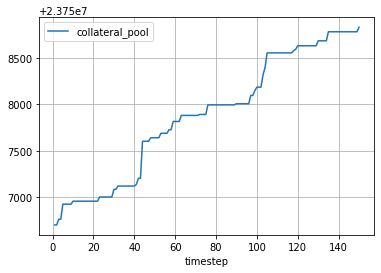

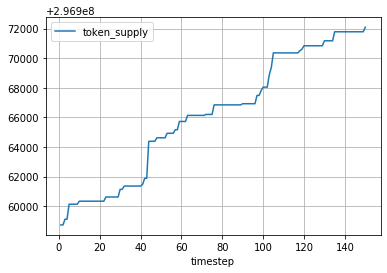

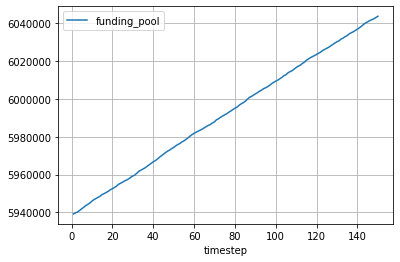

In [7]:
df_final.plot("timestep", "collateral_pool", grid=True)
df_final.plot("timestep", "token_supply", grid=True)
df_final.plot("timestep", "funding_pool", grid=True)

In [8]:
# import matplotlib.pyplot as plt
# supporters = get_edges_by_type(network, 'support')
# influencers = get_edges_by_type(network, 'influence')
# competitors = get_edges_by_type(network, 'conflict')

# nx.draw_kamada_kawai(network, nodelist = get_participants(network), edgelist=influencers)
# plt.title('Participants Social Network')

In [9]:
# For the Flask backend
result = {
    "timestep": list(df_final["timestep"]),
    "funding_pool": list(df_final["funding_pool"]),
    "token_supply": list(df_final["token_supply"]),
    "collateral": list(df_final["collateral_pool"])
}